In [5]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
import ipynbname
from endaaman.ml import fix_global_seed

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)


sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 

os.makedirs('out/figs', exist_ok=True)

fix_global_seed()

print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))

DPI = 600

now working /home/ken/src/github.com/endaaman/bt
デフォルトのフォント: ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']


In [10]:
# df_meta_origins = pd.read_excel('data/meta_origin.xlsx')
# print(df_meta_origins)

# cols = ['name', 'diag_org', 'pred', 'feature']
# df = pd.DataFrame(torch.load('out/compare/LMGAOB/fold5_0/frozen_uni_100/features_test.pt'))[cols]
# df['Dataset'] = 'Local'
# df = pd.merge(df, df_meta_origins, on='name', how='left')
# df.fillna(0, inplace=True)
# df

cv 60349
ebrains 8612
Start projection


/home/ken/.virtualenvs/ml/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Done projection


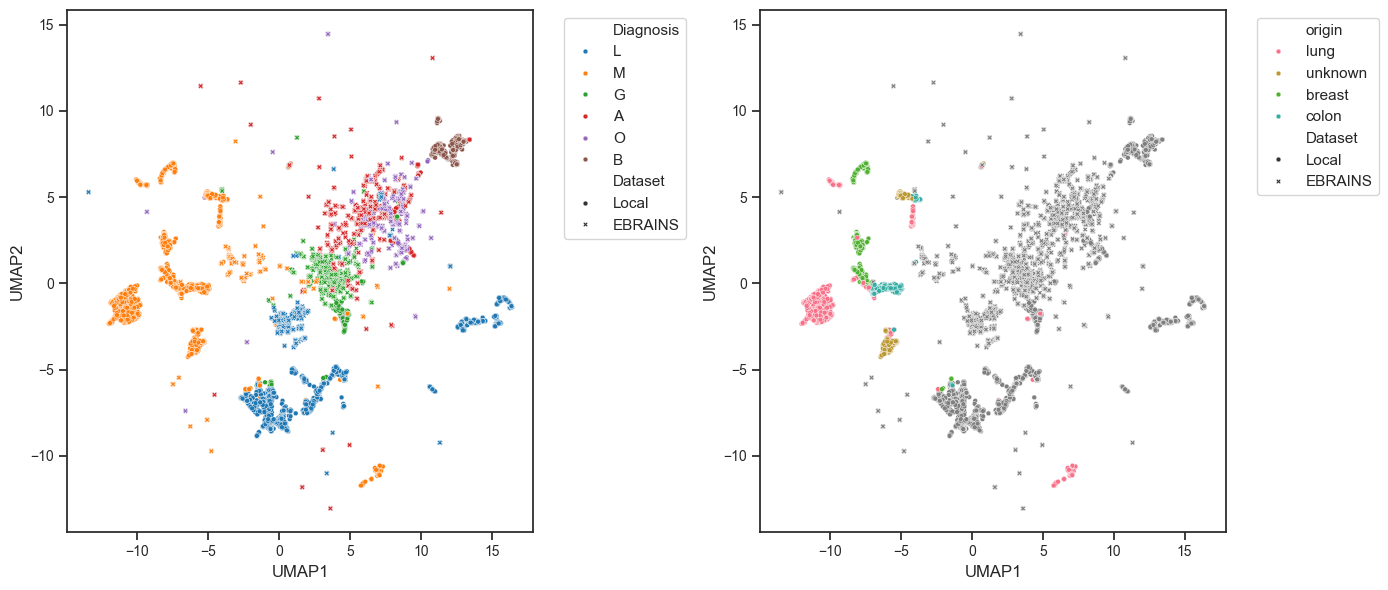

In [29]:
def cluster(cv_pt=None, 
            ebrains_pt=None,
            cv_count_per_case = 20,
            ebrains_count_per_case = -1,
            n_neighbors = 30,
            min_dist = 0.1,
            mode = 'label',
            show = True,
           ):
    if cv_pt is None and ebrains_pt is None:
        raise RuntimeError('At least cv or ebrains must be provided.')

    if ebrains_count_per_case < 0:
        ebrains_count_per_case = cv_count_per_case // 2

    cols = ['name', 'diag_org', 'pred', 'feature']
    
    df = pd.DataFrame([])
    if cv_pt:
        df = pd.DataFrame(torch.load(cv_pt))[cols]
        df['Dataset'] = 'Local'
        df = pd.merge(df, df_meta_origins, on='name', how='left')
        df.fillna('', inplace=True)
        print('cv', len(df))

    if ebrains_pt:
        df_ebrains = pd.DataFrame(torch.load(ebrains_pt))[cols]
        df_ebrains['Dataset'] = 'EBRAINS'
        df_ebrains['origin'] = ''
        print('ebrains', len(df_ebrains))
        df = pd.concat([df_ebrains, df])

    unique_codes = df['diag_org'].unique()
    
    rowss = []
    for name, _rows in df.groupby('name'):
        count = cv_count_per_case if _rows.iloc[0]['Dataset'] == 'Local' else ebrains_count_per_case
        rows = df.loc[np.random.choice(_rows.index, count)]
        rowss.append(rows)

    df = pd.concat(rowss)
    # print(df)

    features = np.stack(df['feature'])
    reducer = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=1,
    )
    print('Start projection')
    embedding = reducer.fit_transform(features)
    print('Done projection')
    df['UMAP1'] = embedding[:, 0]
    df['UMAP2'] = embedding[:, 1]
    df = df.rename(columns={'diag_org': 'Diagnosis'})

    if 'multi':
        fig = plt.figure(figsize=(14, 6))
        ax_label = fig.add_subplot(1, 2, 1)
        ax_origin = fig.add_subplot(1, 2, 2)
    else:
        fig = plt.figure(figsize=(8, 6))
        ax_label = fig.add_subplot(1, 1, 1)
        ax_origin = ax_label

    if mode in ['label', 'multi']:
        g = sns.scatterplot(
            data=df,
            x='UMAP1', y='UMAP2',
            hue='Diagnosis',
            style='Dataset',  
            markers={'Local': 'o', 'EBRAINS': 'X'}, 
            hue_order=unique_codes,
            palette='tab10',
            s=12,
            # alpha=0.7,
            ax=ax_label,
        )
        ax_label.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if mode in ['origin', 'multi']:
        origin_count = len(df['origin'].unique())
        pallete = ['gray'] + list(sns.color_palette('husl'))[:origin_count-1]
        g = sns.scatterplot(
            data=df,
            x='UMAP1', y='UMAP2',
            hue='origin',
            style='Dataset',  
            markers={'Local': 'o', 'EBRAINS': 'X'}, 
            # hue_order=unique_codes,
            palette=pallete,
            s=12,
            # alpha=0.7,
            ax=ax_origin,
        )
        ax_origin.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # if mode == 'multi':
    #     plt.subplots_adjust(wspace=0.5)
    plt.tight_layout()
    plt.show()
    
cluster(
    'out/compare/LMGAOB/fold5_0/frozen_uni_100/features_test.pt',
    'out/compare/LMGAOB/fold5_0/frozen_uni_100/features_ebrains.pt',
    mode = 'multi',
)

cv 60349
ebrains 8612
Start projection


/home/ken/.virtualenvs/ml/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Done projection


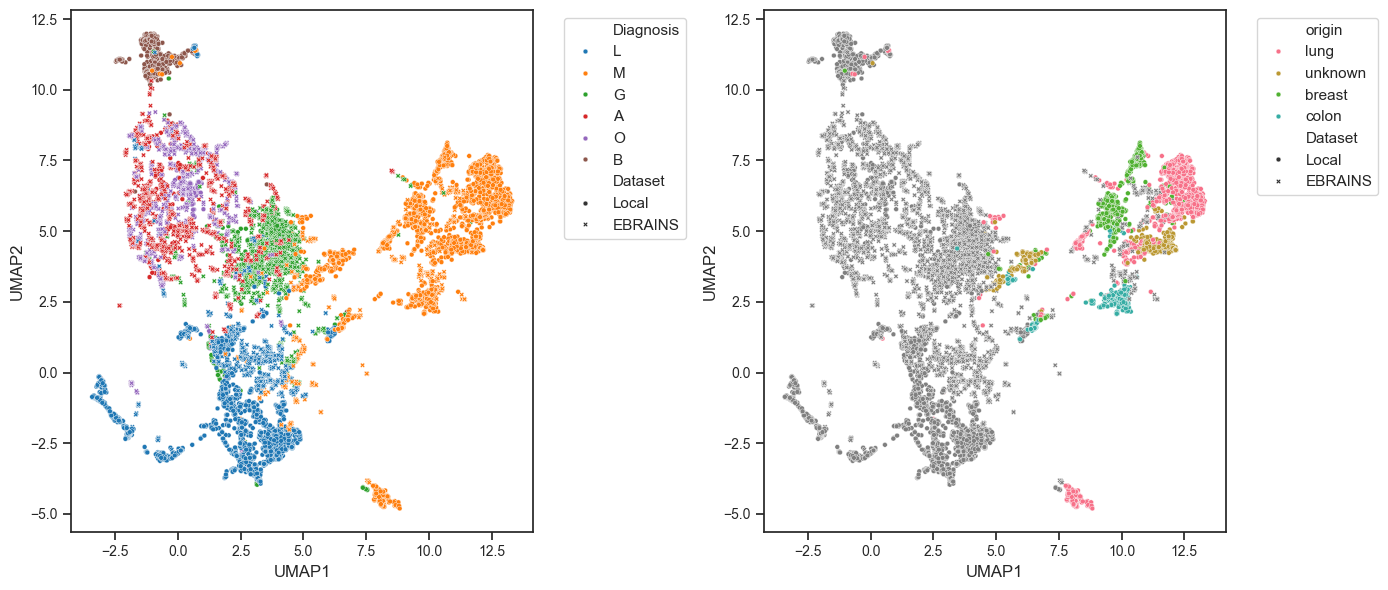

In [30]:
cluster(
    'out/compare/LMGAOB/fold5_0/unfrozen_baseline-vit_100/features_test.pt',
    'out/compare/LMGAOB/fold5_0/unfrozen_baseline-vit_100/features_ebrains.pt',
    mode = 'multi',
)

In [ ]:
cluster(
    'out/compare/LMGAOB/fold5_0/unfrozen_baseline-vit_100/features_test.pt',
    'out/compare/LMGAOB/fold5_0/unfrozen_baseline-vit_100/features_ebrains.pt',
)

In [ ]:
cluster(
    'out/compare/LMGAOB/fold5_0/unfrozen_baseline-cnn_100/features_test.pt',
    'out/compare/LMGAOB/fold5_0/unfrozen_baseline-cnn_100/features_ebrains.pt',
)